In [134]:

# from google.colab import drive
# drive.mount('/content/gdrive')

In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from tensorflow.keras import regularizers

In [136]:
# zip_file_path = '/content/CK+48.zip'  # Path to the uploaded zip file in Colab
# extracted_dir_path = '/content/new'  # Adjust the target directory in Colab
# !unzip -q "$zip_file_path" -d "$extracted_dir_path"

# print("Extraction completed.")

In [137]:
import os
print(os.getcwd())
os.chdir('/content/new/CK+48')
print(os.getcwd())
os.listdir()

/content/new/CK+48
/content/new/CK+48


['surprise', 'contempt', 'sadness', 'anger', 'fear', 'happy', 'disgust']

In [138]:
DATADIR = '/content/new/CK+48'

In [139]:
CATEGORIES = os.listdir(DATADIR)
CATEGORIES

['surprise', 'contempt', 'sadness', 'anger', 'fear', 'happy', 'disgust']

In [140]:
def load_data():
    DATADIR = '/content/new/CK+48'
    data = []
    # loading training data
    for category in CATEGORIES:
        # create path to image of respective expression
        path = os.path.join(DATADIR, category)
        # get the classification  for each expression
        class_num = CATEGORIES.index(category)

        for img in tqdm(os.listdir(path)):
            img_array = cv2.imread(os.path.join(path, img), 0)
            data.append([img_array, class_num])

    return data

In [141]:
data = load_data()

100%|██████████| 177/177 [00:00<00:00, 9356.27it/s]


In [142]:
len(data)

981

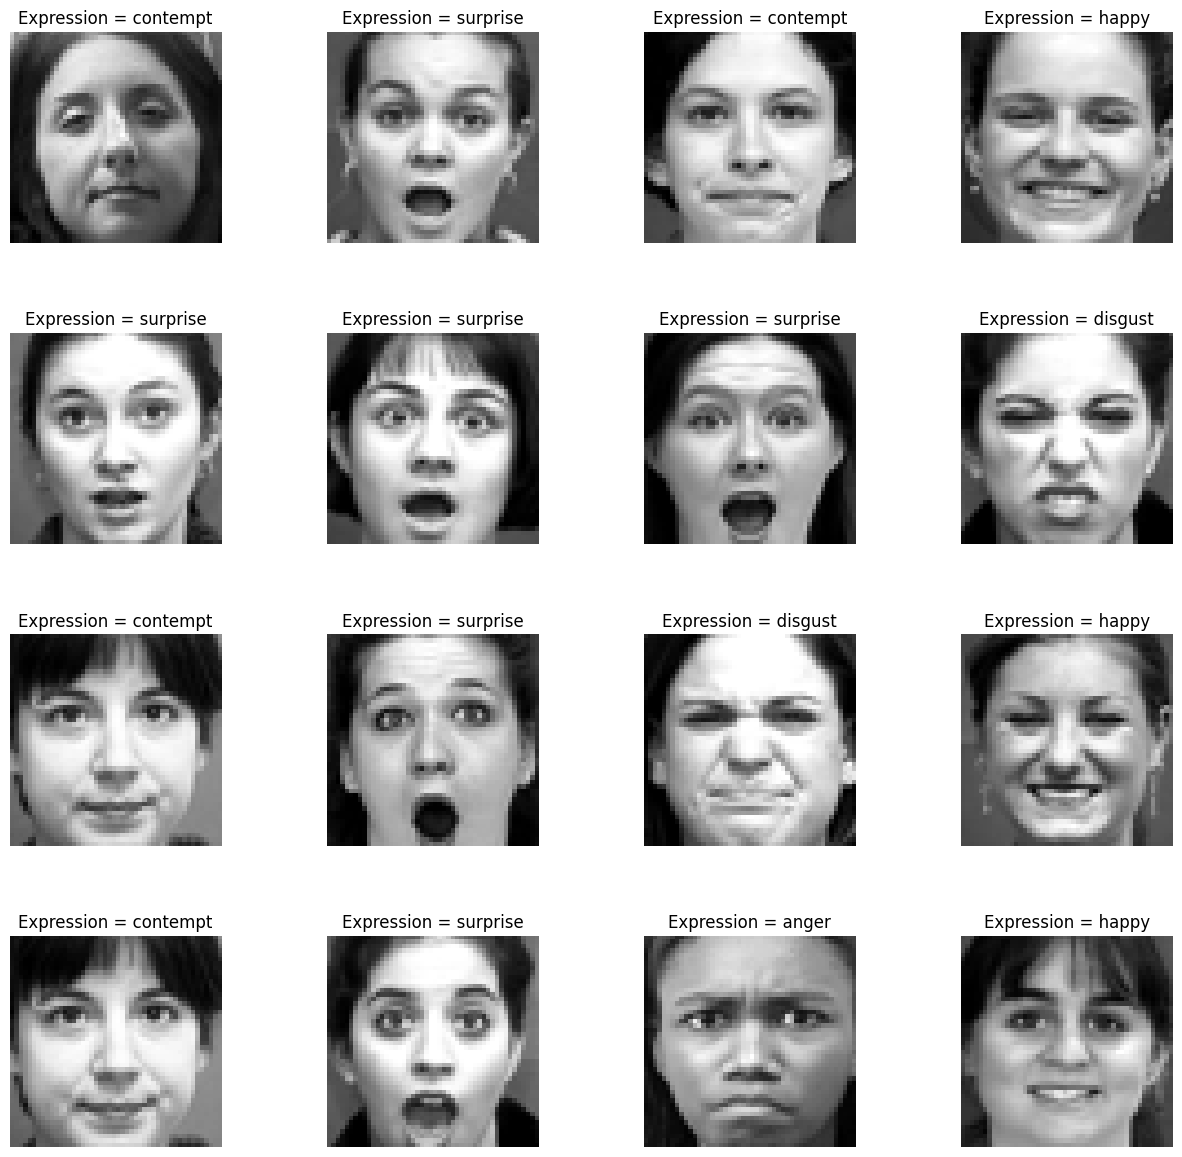

In [143]:
L = 4
W = 4
fig, axes = plt.subplots(L, W, figsize = (15,15))
axes = axes.ravel()

for i in range(0, L * W):
    sample = random.choice(data)
    axes[i].set_title("Expression = "+str(CATEGORIES[sample[1]]))
    axes[i].imshow(sample[0], cmap='gray')
    axes[i].axis('off')
plt.subplots_adjust(wspace=0.5)

In [144]:
X = np.array([ x[0] for x in data])
y = np.array([Y[1] for Y in data])

In [145]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True)

In [146]:
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("-------------------------------")
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (784, 48, 48)
y_train shape:  (784,)
-------------------------------
X_test shape:  (197, 48, 48)
y_test shape:  (197,)


In [147]:
# reshaping y_train and y_test
y_train = np.reshape(y_train, (len(y_train),1))
y_test  = np.reshape(y_test , (len(y_test ),1))

print("After reshaping")
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

After reshaping
y_train shape:  (784, 1)
y_test shape:  (197, 1)


In [148]:
X_train = np.expand_dims(X_train, axis=3)
X_test = np.expand_dims(X_test, axis=3)

print("After adding color channel")
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)

After adding color channel
X_train shape:  (784, 48, 48, 1)
X_test shape:  (197, 48, 48, 1)


In [149]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [150]:
y_train[0]

array([6])

In [151]:
y_train_SVM = y_train
y_test_SVM = y_test

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [152]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [153]:
y_train.shape, y_test.shape

((784, 7), (197, 7))

Feature Extraction

# HOG Technique

In [154]:
from skimage.transform import resize
from skimage.feature import hog

<ipython-input-155-7728609ad122>:10: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(


(-0.5, 47.5, 47.5, -0.5)

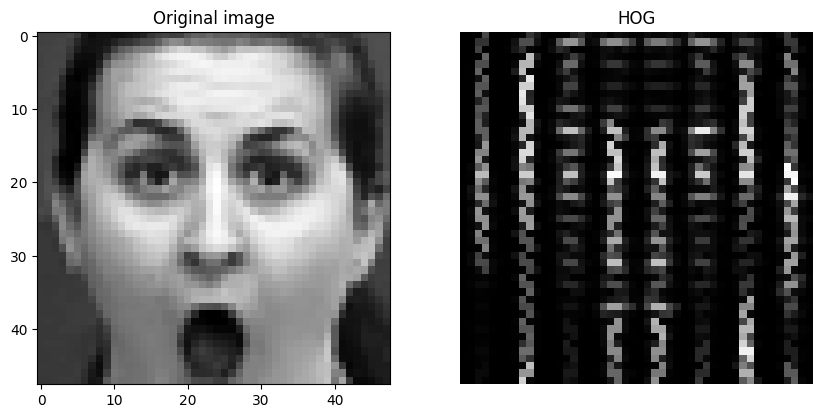

In [155]:
plt.figure(figsize=(10, 10))


plt.subplot(1,2,1)
img = random.choice(X_train)
# first image needs to be resized before passing it to HOG descriptor
resized_img =  resize(img, (128, 64))
plt.title("Original image")
plt.imshow(img, cmap='gray')
fd, hog_image = hog(
    resized_img,
    orientations=9,
    pixels_per_cell=(8, 8),
    cells_per_block=(2, 2),
    visualize=True,
    multichannel=True
)
plt.subplot(1,2,2)
plt.title("HOG")
plt.imshow(resize(hog_image, (48, 48)), cmap='gray')
plt.axis('off')

In [156]:
def Create_Hog_features(data):
    Feature_data = np.zeros((len(data),48,48))

    for i in range(len(data)):
        img = data[i]
        resized_img = resize(img, (128, 64))
        fd, hog_image = hog(
            resized_img,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            visualize=True,
            multichannel=True
        )
        Feature_data[i] = resize(hog_image, (48, 48))
    return Feature_data

In [157]:
Feature_X_train = Create_Hog_features(X_train)
Feature_X_train.shape

<ipython-input-156-d9473ffe5e27>:7: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(


(784, 48, 48)

(-0.5, 47.5, 47.5, -0.5)

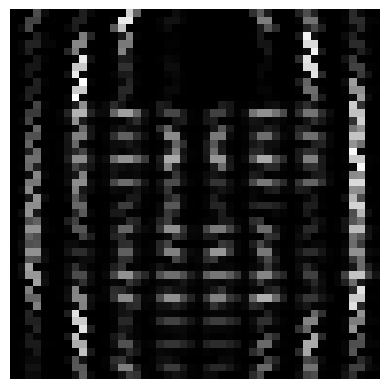

In [158]:
plt.imshow(random.choice(Feature_X_train), cmap='gray')
plt.axis('off')

In [159]:
# doing same for test data
Feature_X_test = Create_Hog_features(X_test)

Feature_X_test.shape

<ipython-input-156-d9473ffe5e27>:7: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(


(197, 48, 48)

(-0.5, 47.5, 47.5, -0.5)

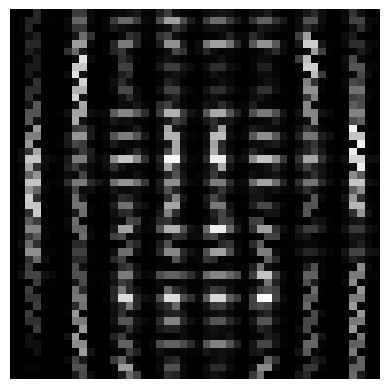

In [160]:
plt.imshow(random.choice(Feature_X_test), cmap='gray')
plt.axis('off')

In [161]:
# Again adding color channel as it got removed while converting img to hog img
X_train_HOG = np.expand_dims(Feature_X_train, axis=3)
X_test_HOG = np.expand_dims(Feature_X_test, axis=3)

print("After adding color channel")
print("X_train_HOG shape: ", X_train_HOG.shape)
print("X_test_HOG shape: ", X_test_HOG.shape)

After adding color channel
X_train_HOG shape:  (784, 48, 48, 1)
X_test_HOG shape:  (197, 48, 48, 1)


In [162]:
print("X_train_HOG shape: ", X_train_HOG.shape)
print("y_train shape: ", y_train.shape)
print("X_test_HOG shape: ", X_test_HOG.shape)
print("y_test shape: ", y_test.shape)

X_train_HOG shape:  (784, 48, 48, 1)
y_train shape:  (784, 7)
X_test_HOG shape:  (197, 48, 48, 1)
y_test shape:  (197, 7)


In [163]:
def create_model(input_shape=None):
    if input_shape is None :
        input_shape=(48,48,1)

    model = Sequential()
    model.add(Conv2D(6, (5, 5), input_shape=input_shape, padding='same', activation = 'relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Conv2D(16, (5, 5), padding='same', activation = 'relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation = 'relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(7, activation = 'softmax'))

    return model

In [164]:
es = EarlyStopping(
    monitor='val_accuracy', min_delta=0.0001, patience=10, verbose=2,
    mode='max', baseline=None, restore_best_weights=True
)
lr = ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.1, patience=5, verbose=2,
    mode='max', min_delta=1e-5, cooldown=0, min_lr=0
)

callbacks = [es, lr]

In [165]:
HOG_model = create_model()

In [166]:
HOG_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 48, 48, 6)         156       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 24, 24, 6)        0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 24, 24, 16)        2416      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 12, 12, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 10, 10, 64)        9280      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 5, 5, 64)        

In [167]:
HOG_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam' )

In [169]:
HOG_history = HOG_model.fit(X_train_HOG, y_train, batch_size=8 , epochs= 80 , validation_data = (X_test_HOG, y_test), callbacks = [callbacks])

Epoch 1/80
98/98 [==============================] - 1s 7ms/step - loss: 1.8451 - accuracy: 0.2449 - val_loss: 1.8309 - val_accuracy: 0.2132 - lr: 0.0010
Epoch 2/80
98/98 [==============================] - 1s 5ms/step - loss: 1.7385 - accuracy: 0.2972 - val_loss: 1.7143 - val_accuracy: 0.3503 - lr: 0.0010
Epoch 3/80
98/98 [==============================] - 1s 5ms/step - loss: 1.5096 - accuracy: 0.4643 - val_loss: 1.3497 - val_accuracy: 0.5279 - lr: 0.0010
Epoch 4/80
98/98 [==============================] - 1s 5ms/step - loss: 1.1921 - accuracy: 0.5765 - val_loss: 1.0986 - val_accuracy: 0.5787 - lr: 0.0010
Epoch 5/80
98/98 [==============================] - 1s 6ms/step - loss: 1.0279 - accuracy: 0.6212 - val_loss: 0.9815 - val_accuracy: 0.6244 - lr: 0.0010
Epoch 6/80
98/98 [==============================] - 1s 5ms/step - loss: 0.9172 - accuracy: 0.6671 - val_loss: 0.8896 - val_accuracy: 0.6345 - lr: 0.0010
Epoch 7/80
98/98 [==============================] - 1s 5ms/step - loss: 0.8313 - a

In [170]:
def plot_performance(history):
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')

    plt.legend()
    plt.grid()
    plt.title('train and val loss evolution')

    plt.subplot(2, 1, 2)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')

    plt.legend()
    plt.grid()
    plt.title('train and val accuracy')

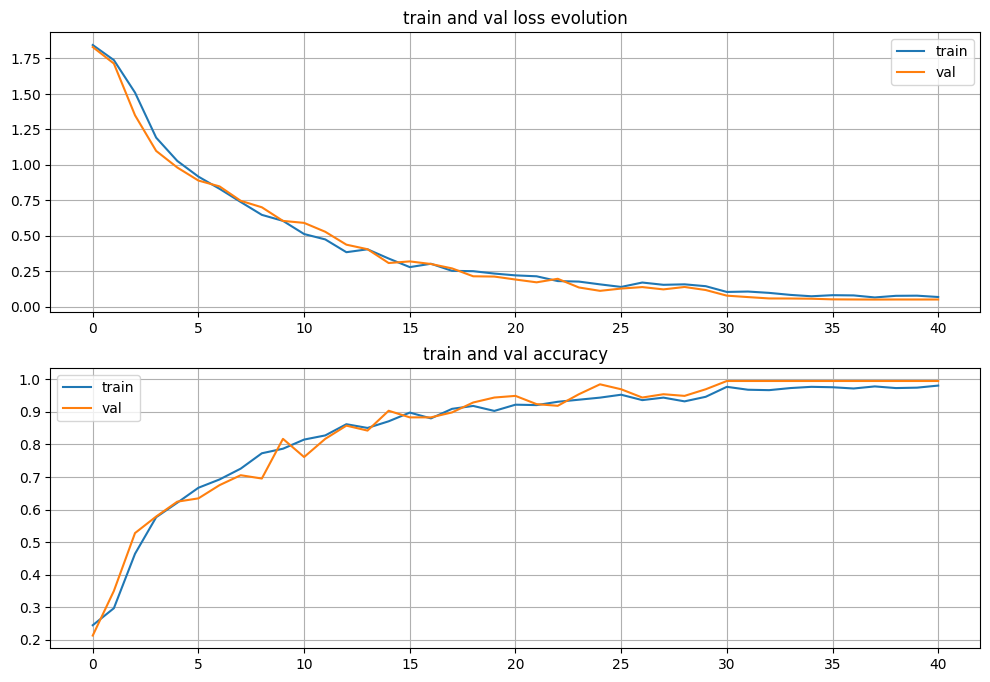

In [171]:
plot_performance(HOG_history)

In [172]:
acc = []

In [173]:
HOG_acc = HOG_model.evaluate(X_test_HOG, y_test, verbose = 0)[1]
acc.append(HOG_acc)
print("HOG Accuracy :",HOG_model.evaluate(X_test_HOG, y_test, verbose = 0)[1])

HOG Accuracy : 0.9949238300323486


In [174]:
HOG_model.save('HOG_model.h5')

# LBP technqiue


In [175]:
def Binarypattern(im):                               # creating function to get local binary pattern
    img= np.zeros_like(im)
    n=3                                              # taking kernel of size 3*3
    for i in range(0,im.shape[0]-n):                 # for image height
        for j in range(0,im.shape[1]-n):               # for image width
            x  = im[i:i+n,j:j+n]                     # reading the entire image in 3*3 format
            center       = x[1,1]                    # taking the center value for 3*3 kernel
            img1        = (x >= center)*1.0          # checking if neighbouring values of center value is greater or less than center value
            img1_vector = img1.T.flatten()           # getting the image pixel values
            img1_vector = np.delete(img1_vector,4)
            digit = np.where(img1_vector)[0]
            if len(digit) >= 1:                     # converting the neighbouring pixels according to center pixel value
                num = np.sum(2**digit)              # if n> center assign 1 and if n<center assign 0
            else:                                    # if 1 then multiply by 2^digit and if 0 then making value 0 and aggregating all the values of kernel to get new center value
                num = 0
            img[i+1,j+1] = num
    return(img)

(-0.5, 47.5, 47.5, -0.5)

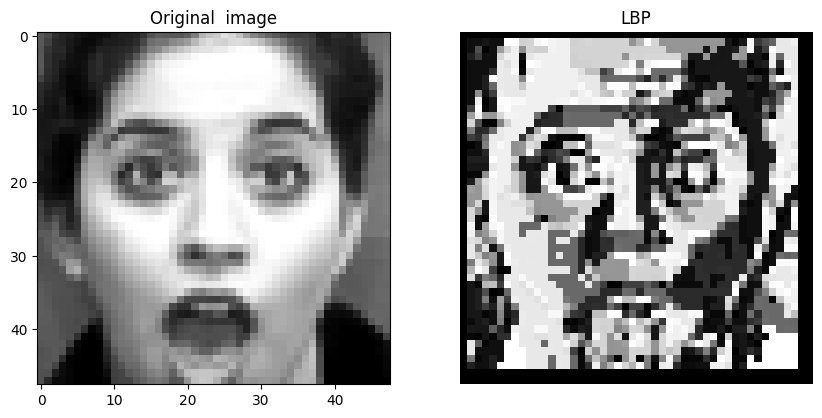

In [176]:
plt.figure(figsize = (10,10))

plt.subplot(1,2,1)
img = random.choice(X_train)
plt.title("Original  image")
plt.imshow(img, cmap='gray')

plt.subplot(1,2,2)
plt.title("LBP")
imgLBP=Binarypattern(img)             # calling the LBP function using gray image
plt.imshow(imgLBP, cmap='gray')
plt.axis('off')

In [177]:
X_train.shape

(784, 48, 48, 1)

In [178]:
def create_LBP_features(data):
    Feature_data = np.zeros(data.shape)

    for i in range(len(data)):
        img = data[i]
        imgLBP=Binarypattern(img)
        Feature_data[i] = imgLBP

    return Feature_data

In [179]:
Feature_X_train = create_LBP_features(X_train)

In [180]:
Feature_X_train.shape

(784, 48, 48, 1)

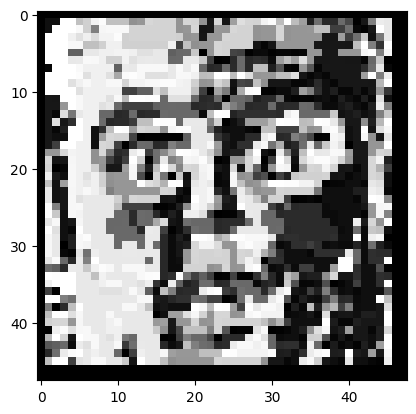

In [181]:
img = random.choice(Feature_X_train)
plt.imshow(img, cmap='gray')

In [182]:
Feature_X_test = create_LBP_features(X_test)
Feature_X_test.shape

(197, 48, 48, 1)

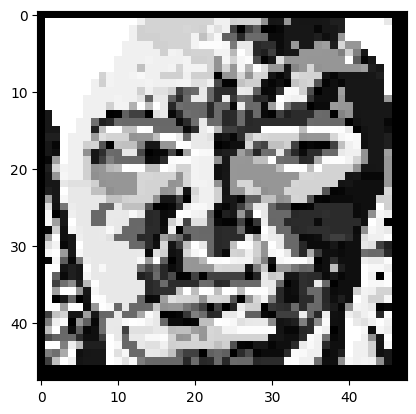

In [183]:
img = random.choice(Feature_X_test)
plt.imshow(img, cmap='gray')

# Training Model

In [184]:
LBP_model = create_model()
LBP_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam' )

In [185]:
LBP_history = LBP_model.fit(Feature_X_train, y_train, batch_size=8 , epochs=80, validation_data = (Feature_X_test, y_test) ,callbacks = [callbacks])

Epoch 1/80
98/98 [==============================] - 3s 7ms/step - loss: 4.2615 - accuracy: 0.2589 - val_loss: 1.7263 - val_accuracy: 0.3807 - lr: 0.0010
Epoch 2/80
98/98 [==============================] - 1s 5ms/step - loss: 1.5438 - accuracy: 0.4349 - val_loss: 1.5043 - val_accuracy: 0.4569 - lr: 0.0010
Epoch 3/80
98/98 [==============================] - 1s 9ms/step - loss: 1.2815 - accuracy: 0.5510 - val_loss: 1.2193 - val_accuracy: 0.5431 - lr: 0.0010
Epoch 4/80
98/98 [==============================] - 1s 8ms/step - loss: 0.9984 - accuracy: 0.6441 - val_loss: 1.0701 - val_accuracy: 0.5888 - lr: 0.0010
Epoch 5/80
98/98 [==============================] - 1s 8ms/step - loss: 0.8075 - accuracy: 0.7194 - val_loss: 0.7329 - val_accuracy: 0.7107 - lr: 0.0010
Epoch 6/80
98/98 [==============================] - 1s 7ms/step - loss: 0.5964 - accuracy: 0.7895 - val_loss: 0.6958 - val_accuracy: 0.7310 - lr: 0.0010
Epoch 7/80
98/98 [==============================] - 1s 8ms/step - loss: 0.4171 - a

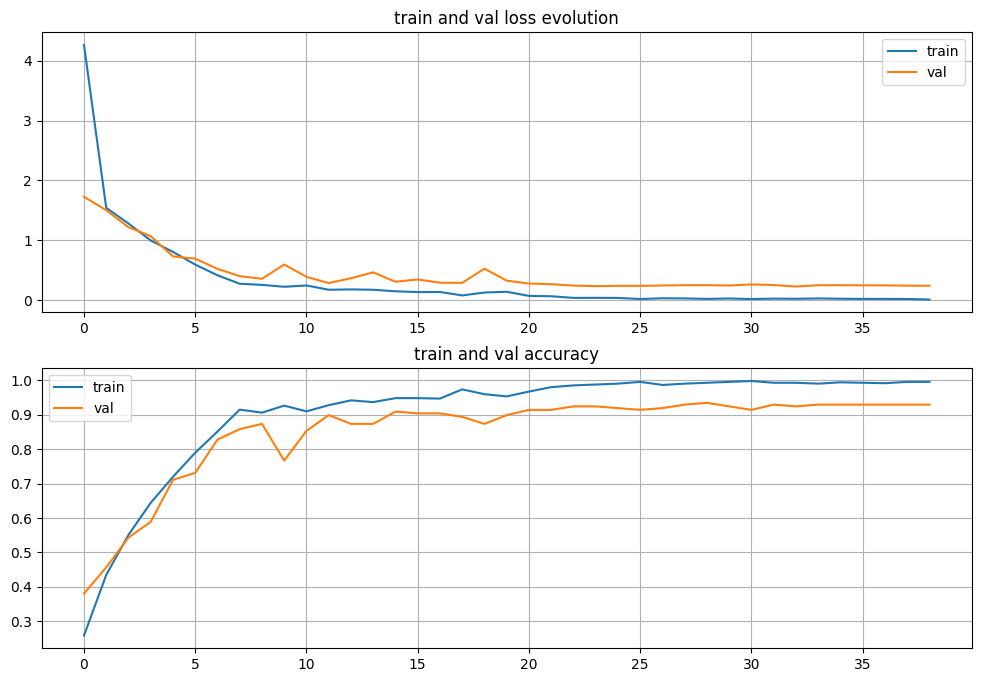

In [186]:
plot_performance(LBP_history)

In [187]:
LBP_acc = LBP_model.evaluate(Feature_X_test, y_test, verbose = 0)[1]
acc.append(LBP_acc)
print("LBP Accuracy :",LBP_model.evaluate(Feature_X_test, y_test, verbose = 0)[1])

LBP Accuracy : 0.9340101480484009


In [188]:
LBP_model.save('LBP_model.h5')

##Combined of HOG and LBP

In [189]:
def create_combined_features(data):
    Feature_data = np.zeros((len(data), 48, 48, 2))  # Create an array to store combined features

    for i in range(len(data)):
        img = data[i]
        resized_img = resize(img, (128, 64))

        # Extract HOG features
        fd_hog, hog_image = hog(
            resized_img,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            visualize=True,
            multichannel=True
        )

        # Extract LBP features
        img_lbp = Binarypattern(img)
        img_lbp = img_lbp[:, :, 0]  # Remove the last dimension

        # Store the combined features
        Feature_data[i, :, :, 0] = resize(hog_image, (48, 48))
        Feature_data[i, :, :, 1] = img_lbp

    return Feature_data


In [190]:
# Create the combined features for training data
Feature_X_train = create_combined_features(X_train)
print("Combined feature shape:", Feature_X_train.shape)

<ipython-input-189-bb059192a040>:9: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd_hog, hog_image = hog(


Combined feature shape: (784, 48, 48, 2)


In [191]:
# Create the combined features for test data
Feature_X_test = create_combined_features(X_test)
print("Combined feature shape:", Feature_X_test.shape)


<ipython-input-189-bb059192a040>:9: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd_hog, hog_image = hog(


Combined feature shape: (197, 48, 48, 2)


In [192]:
# Modify the model to handle the combined features
def create_model(input_shape=None):
    if input_shape is None:
        input_shape = (48, 48, 2)  # Update input shape for combined features

    model = Sequential()
    model.add(Conv2D(6, (5, 5), input_shape=input_shape, padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Conv2D(16, (5, 5), padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(7, activation='softmax'))

    return model

In [193]:
# Create and compile the model
combined_model = create_model(input_shape=(48, 48, 2))
combined_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [194]:
# Train the model on combined features
combined_history = combined_model.fit(Feature_X_train, y_train, batch_size=8, epochs=80,
                                      validation_data=(Feature_X_test, y_test), callbacks=[callbacks])

Epoch 1/80
98/98 [==============================] - 3s 11ms/step - loss: 7.4876 - accuracy: 0.2423 - val_loss: 1.8681 - val_accuracy: 0.2183 - lr: 0.0010
Epoch 2/80
98/98 [==============================] - 1s 8ms/step - loss: 1.8523 - accuracy: 0.2857 - val_loss: 1.8145 - val_accuracy: 0.3147 - lr: 0.0010
Epoch 3/80
98/98 [==============================] - 1s 8ms/step - loss: 1.7628 - accuracy: 0.3099 - val_loss: 1.6462 - val_accuracy: 0.4264 - lr: 0.0010
Epoch 4/80
98/98 [==============================] - 1s 9ms/step - loss: 1.6577 - accuracy: 0.3406 - val_loss: 1.5715 - val_accuracy: 0.4162 - lr: 0.0010
Epoch 5/80
98/98 [==============================] - 1s 8ms/step - loss: 1.4589 - accuracy: 0.4273 - val_loss: 1.4033 - val_accuracy: 0.5025 - lr: 0.0010
Epoch 6/80
98/98 [==============================] - 1s 9ms/step - loss: 1.3236 - accuracy: 0.4528 - val_loss: 1.1640 - val_accuracy: 0.5939 - lr: 0.0010
Epoch 7/80
98/98 [==============================] - 1s 8ms/step - loss: 1.1930 - 

In [195]:
# Evaluate the model on combined features
combined_acc = combined_model.evaluate(Feature_X_test, y_test, verbose=0)[1]
acc.append(combined_acc)
print("Combined Features Accuracy:", combined_acc)

Combined Features Accuracy: 0.9695431590080261


In [196]:
# Save the model
combined_model.save('Combined_model.h5')